In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv


# 2nd writing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

/opt/conda/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [5]:
df_origi = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')

In [6]:
df_origi.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [7]:
df_origi.shape

(32581, 12)

In [8]:
df_train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [9]:
df_train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
def drop_id(df):
    df_drop = df.drop(columns = ['id'])
    return df_drop

In [11]:
df_train = drop_id(df_train)
df_test = drop_id(df_test)

In [12]:
df_train.shape, df_test.shape

((58645, 12), (39098, 11))

In [13]:
df_train = pd.concat([df_train, df_origi], axis = 0)

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [15]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [16]:
def stacked_bar_plot(df, feature, target = 'loan_status'):
    
    crosstab = pd.crosstab(df[feature], df[target], normalize = 'index')
    crosstab.plot(kind = 'bar', stacked = True, figsize = (12,6), cmap = 'viridis')
    
    plt.title(f'Stacked Bar Plot of {feature} and {target}')
    plt.ylabel('Proportion')
    plt.show()

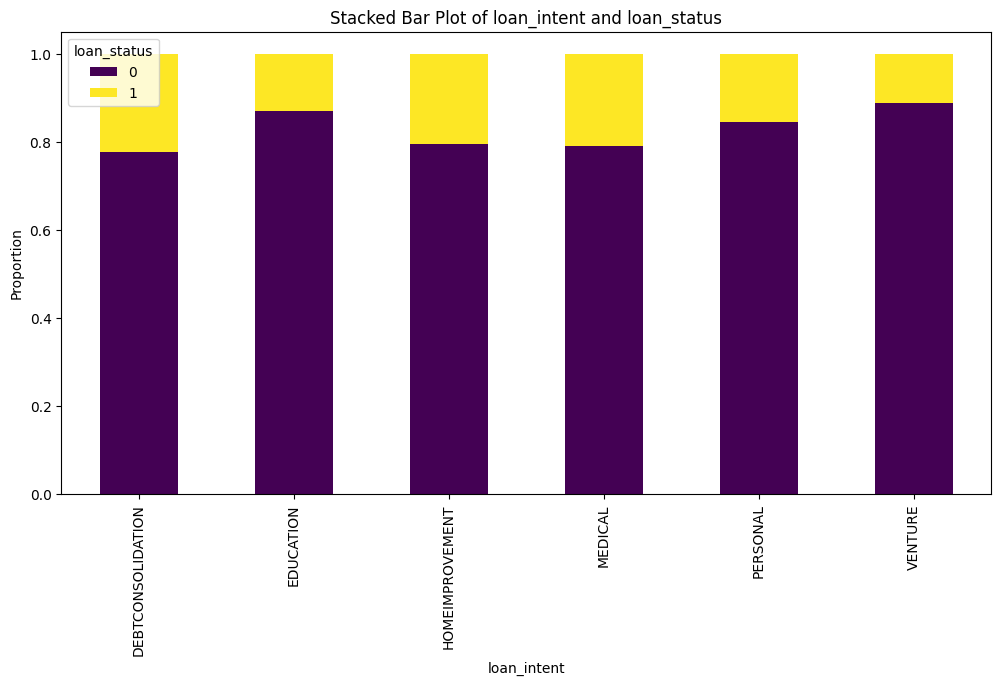

In [17]:
stacked_bar_plot(df_train, 'loan_intent', 'loan_status')

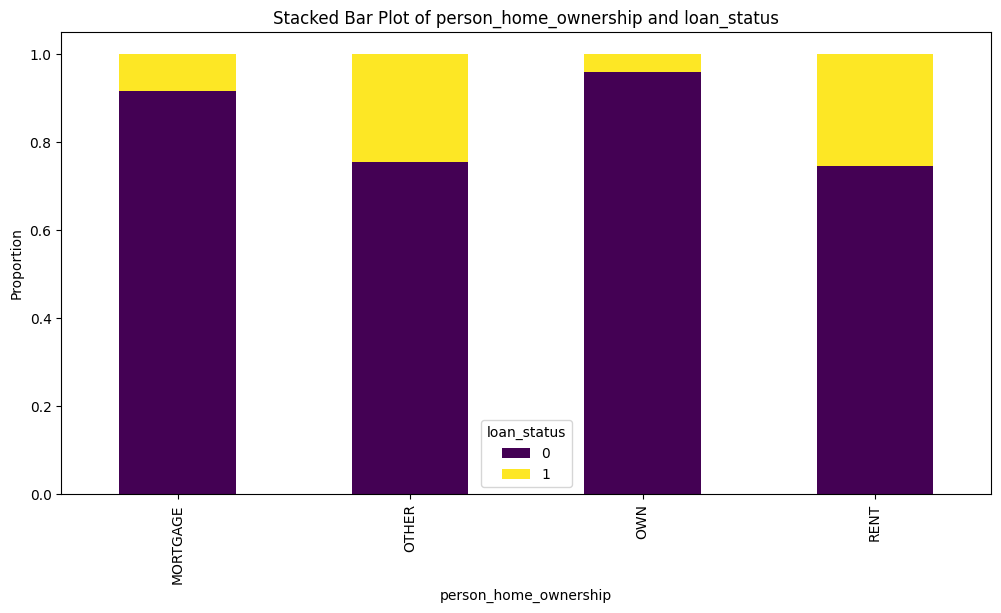

In [18]:
stacked_bar_plot(df_train, 'person_home_ownership')

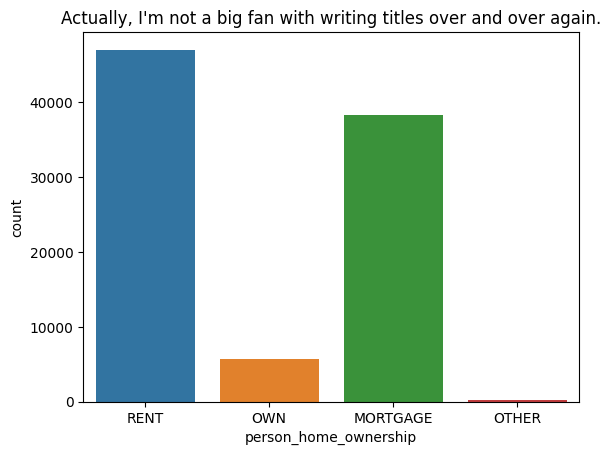

In [19]:
sns.countplot(data = df_train, x = 'person_home_ownership')
plt.title('Actually, I\'m not a big fan with writing titles over and over again.')
plt.show()

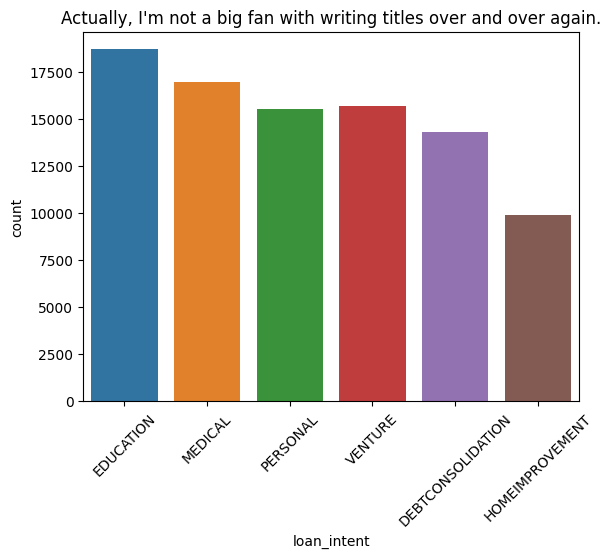

In [20]:
sns.countplot(data = df_train, x = 'loan_intent')
plt.title('Actually, I\'m not a big fan with writing titles over and over again.')

plt.xticks(rotation = 45)
plt.show()

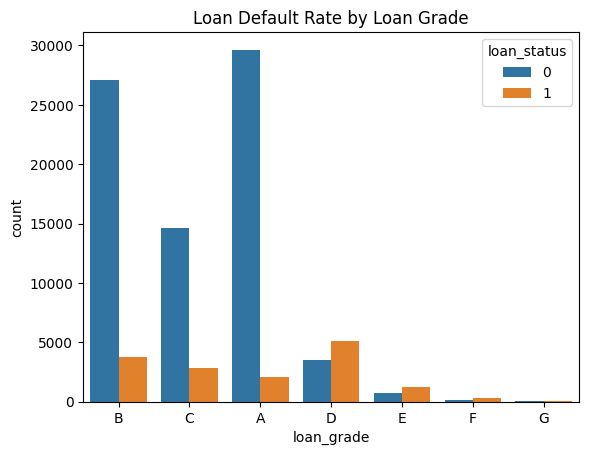

In [21]:
sns.countplot(data=df_train, x='loan_grade', hue='loan_status')
plt.title('Loan Default Rate by Loan Grade')
plt.show()

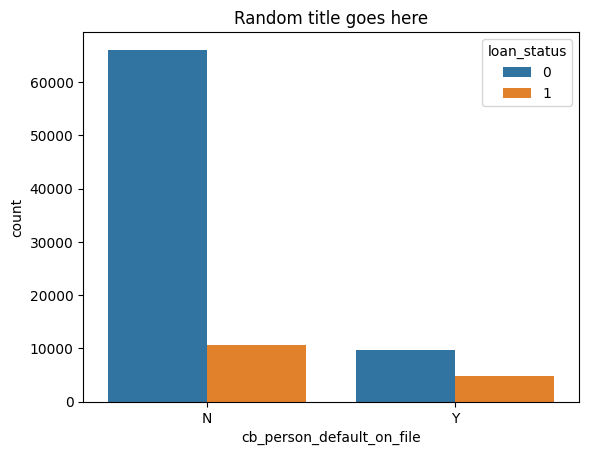

In [22]:
sns.countplot(data = df_train, x = 'cb_person_default_on_file', 
             hue = 'loan_status')
plt.title('Random title goes here')
plt.show()

In [23]:
def plt_boxplots(df, columns):
    plt.figure(figsize = (12,6))
    
    for i, col in enumerate(columns, start = 1):
        plt.subplot(1, len(columns), i)
        sns.boxplot(y = df[col], color = 'lightgray')
        plt.title(f"Box plot of {col}")
    
    plt.tight_layout()
    plt.show()

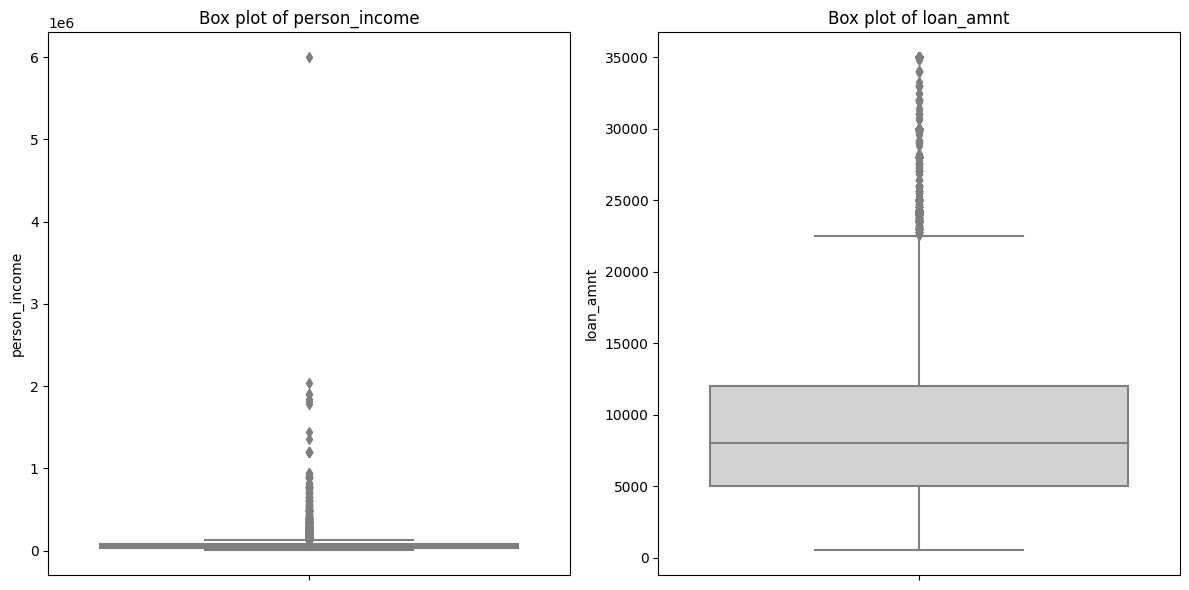

In [24]:
plt_boxplots(df_train, ['person_income', 'loan_amnt'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


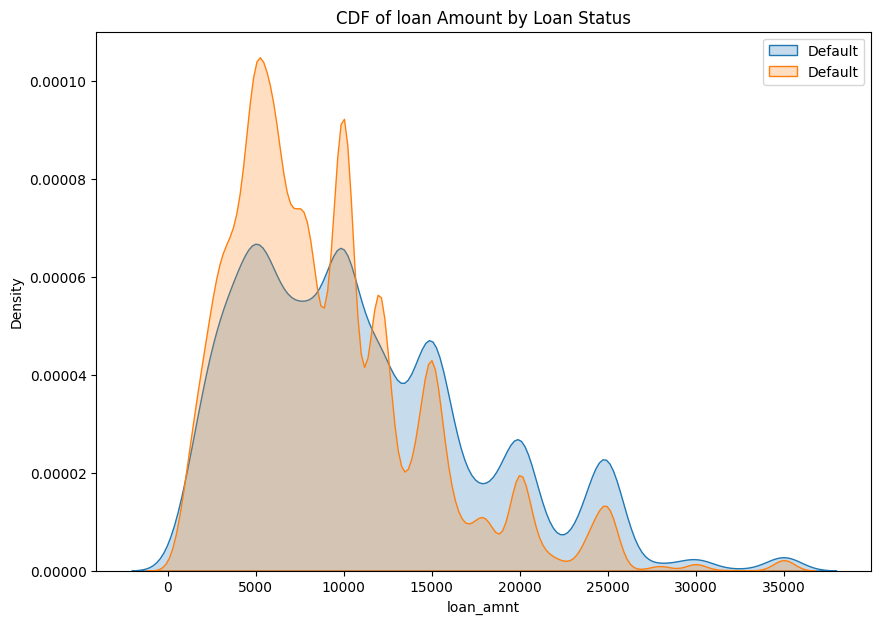

In [25]:
def plt_kdeplot(df, feature1, feature2 = 'loan_amnt'):
    plt.figure(figsize = (10,7))
    
    sns.kdeplot(df[df[feature1] == 1][feature2],
               label = 'Default', fill = True)
    sns.kdeplot(df[df[feature1] == 0][feature2],
               label = 'Default', fill = True)
    
    plt.title('CDF of loan Amount by Loan Status')
    plt.xlabel("loan_amnt")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
plt_kdeplot(df_train, "loan_status")

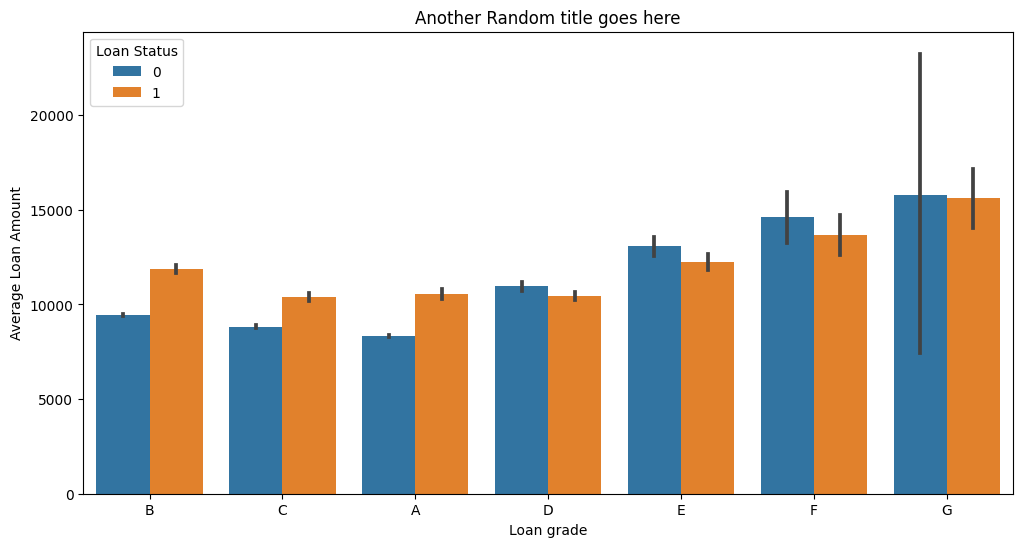

In [26]:
def compare_barplt(df, ft1, ft2):
    plt.figure(figsize = (12,6))
    
    sns.barplot(x = ft1, y = ft2, hue = 'loan_status', data = df,
               estimator = np.mean)
    
    plt.title("Another Random title goes here")
    plt.xlabel("Loan grade")
    plt.ylabel("Average Loan Amount")
    plt.legend(title = 'Loan Status')
    plt.show()
    
compare_barplt(df_train, 'loan_grade', 'loan_amnt')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

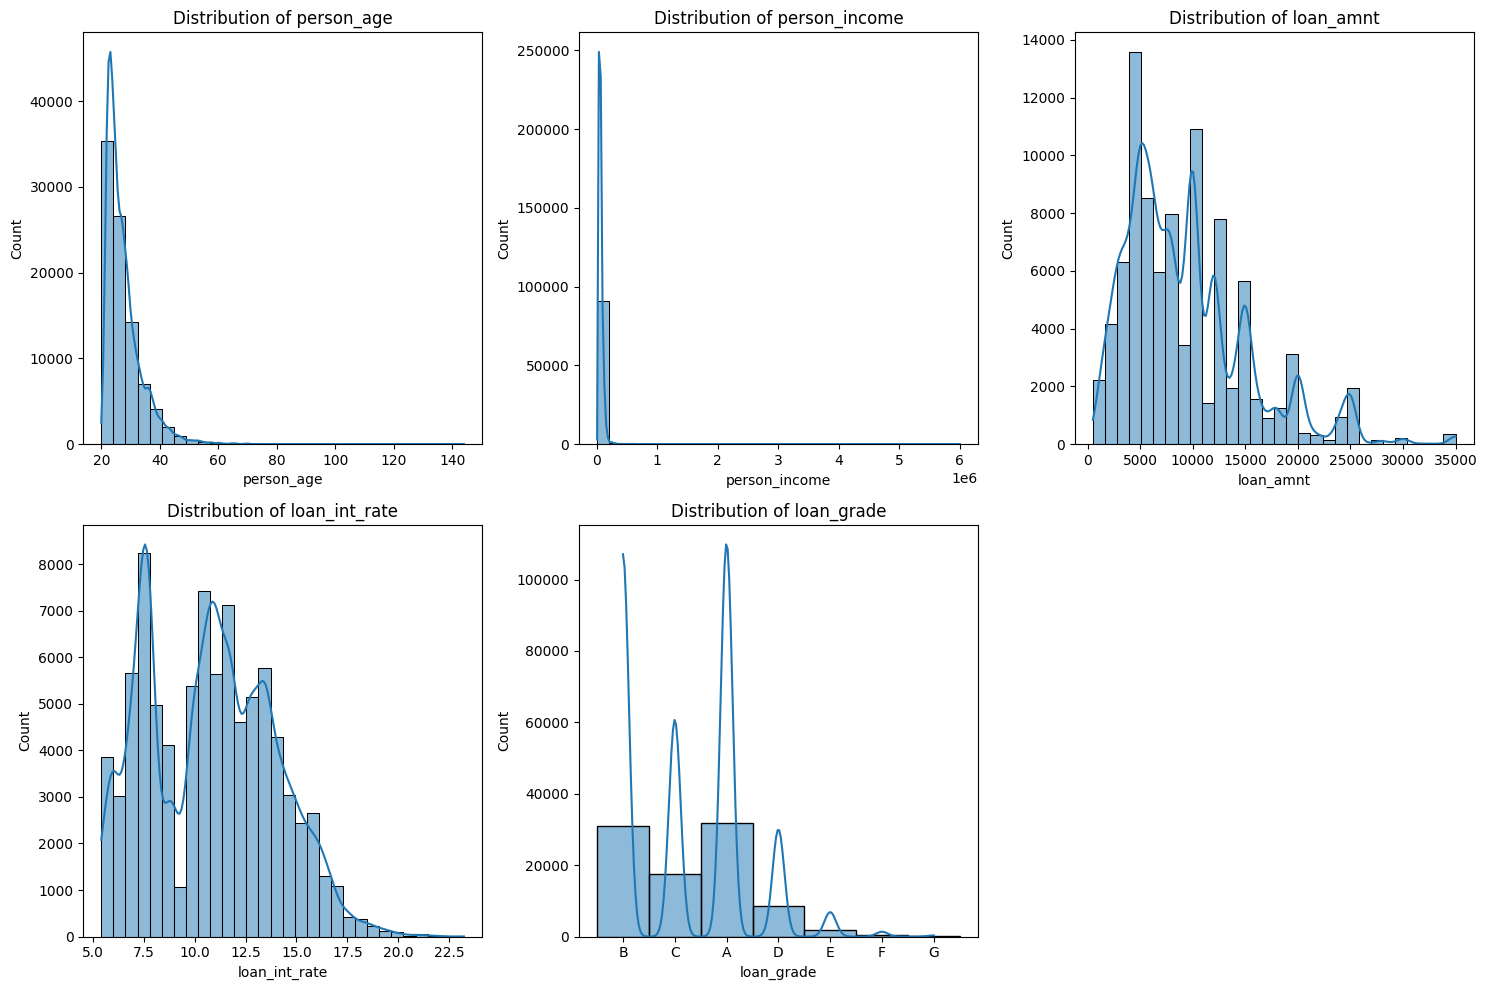

In [27]:
def multi_hist(df, features): #assumes that we use under 6 features olny
    plt.figure(figsize = (15,10))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(2,3,i)
        sns.histplot(df[feature], bins = 30, kde = True)
        plt.title(f"Distribution of {feature}")
    
    plt.tight_layout()
    plt.show()
    
multi_hist(df_train, ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_grade'])

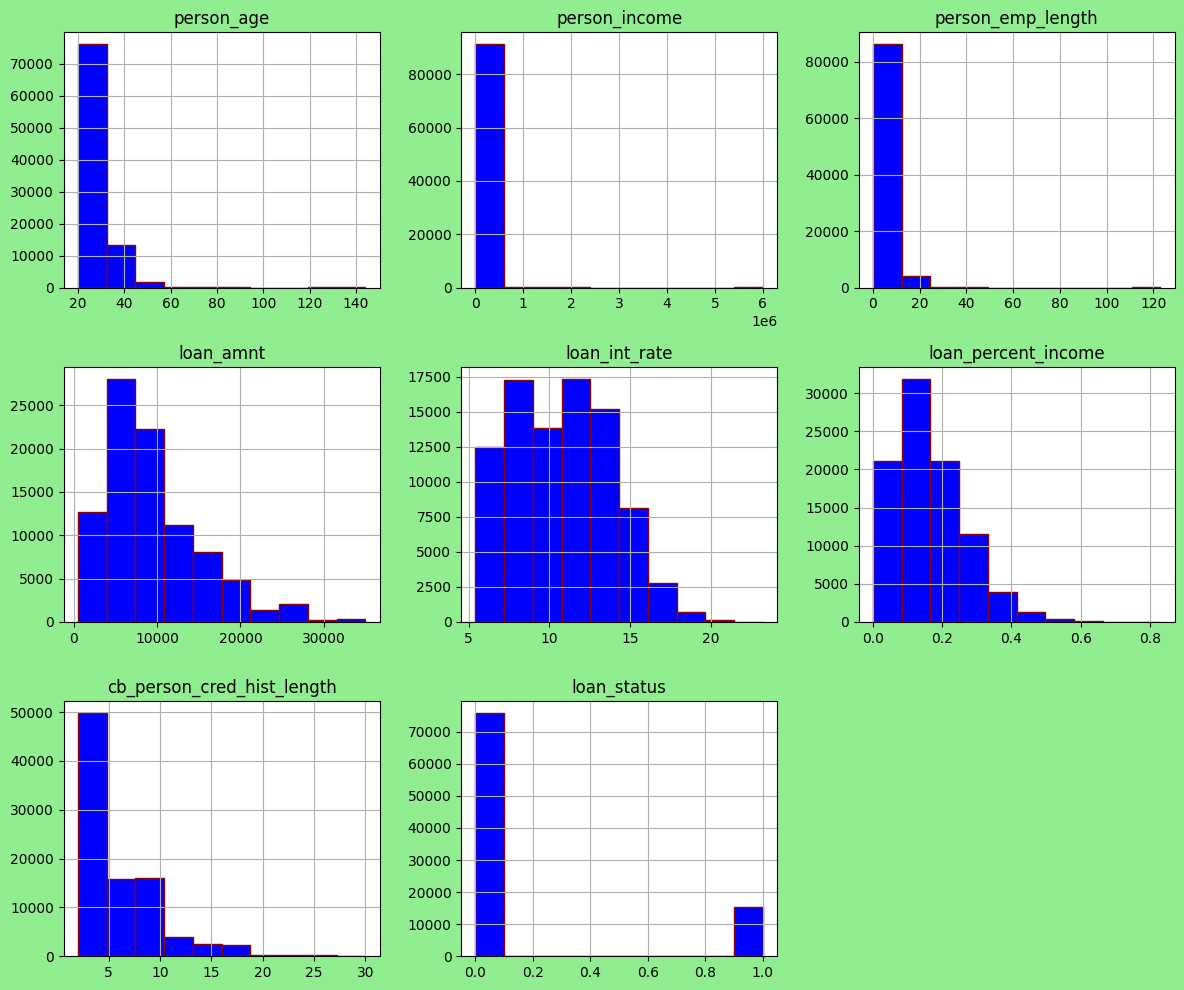

In [28]:
df_train.hist(figsize=(12, 10), color='blue', edgecolor='darkred')
plt.gcf().set_facecolor('lightgreen')
plt.tight_layout()
plt.show()

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

ValueError: cannot reindex on an axis with duplicate labels

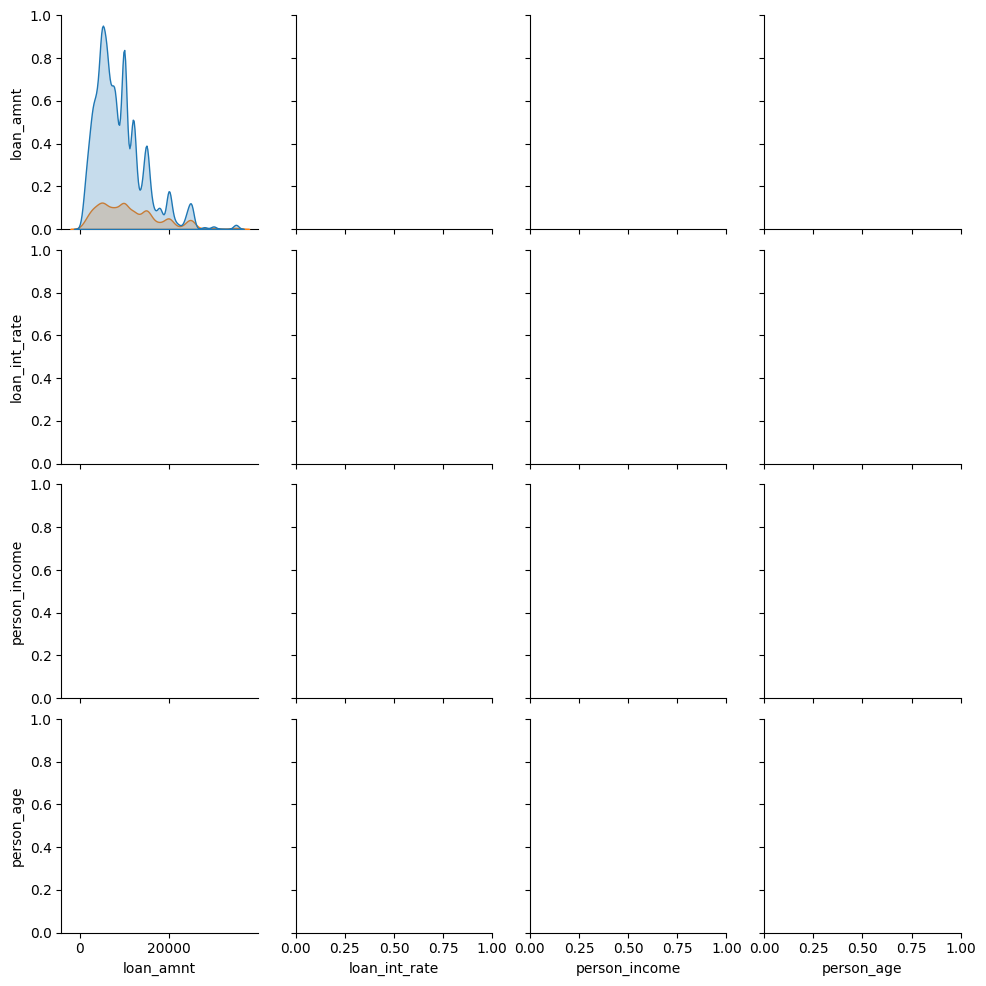

In [30]:
subset_features = ['loan_amnt', 'loan_int_rate', 'person_income', 
                   'person_age', 'loan_status']

sns.pairplot(df_train[subset_features], hue = 'loan_status')
plt.title("Pair plot of selected features")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']

def preprocess_data(df_train, df_test, features = label_cols):
    label_enc = LabelEncoder()
    
    for col in features:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])
        
    df_train = pd.get_dummies(df_train, columns = ['loan_intent'],
                             drop_first = True)
    df_test = pd.get_dummies(df_test, columns = ['loan_intent'],
                             drop_first = True)
    
    target_col = 'loan_status'
    train_columns = df_train.drop(columns = [target_col]).columns
    df_test = df_test.reindex(columns = train_columns, fill_value = 0)
    
    return df_train, df_test

In [ ]:
df_train_processed, df_test_processed = preprocess_data(df_train, df_test)

In [ ]:
df_train.shape,df_test.shape

In [ ]:
def corr_heatmap(df, cmap):
    corr_mat = df_train.corr()
    plt.figure(figsize = (15,6))
    
    sns.heatmap(carr_mat, annot = True, cmap = cmap, fmt = ".1f"
               , linewidths = 0.2)
    
    plt.gcf().set_facecolor("#00FFFF")
    plt.title("Corr Matrix")
    plt.show

In [ ]:
corr_heatmap(df_train, 'viridis')